In [14]:
%%capture
%pip install matplotlib seaborn

In [32]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import comb

sns.set_theme(style="ticks", palette="pastel")

RESULTS_FILE = "/Users/tobydrane/Documents/Repos/atla-tau-bench/results/tool-calling-gpt-4o-mini-0.0_range_0--1_user-gpt-4o-mini-llm_0408083827.json"

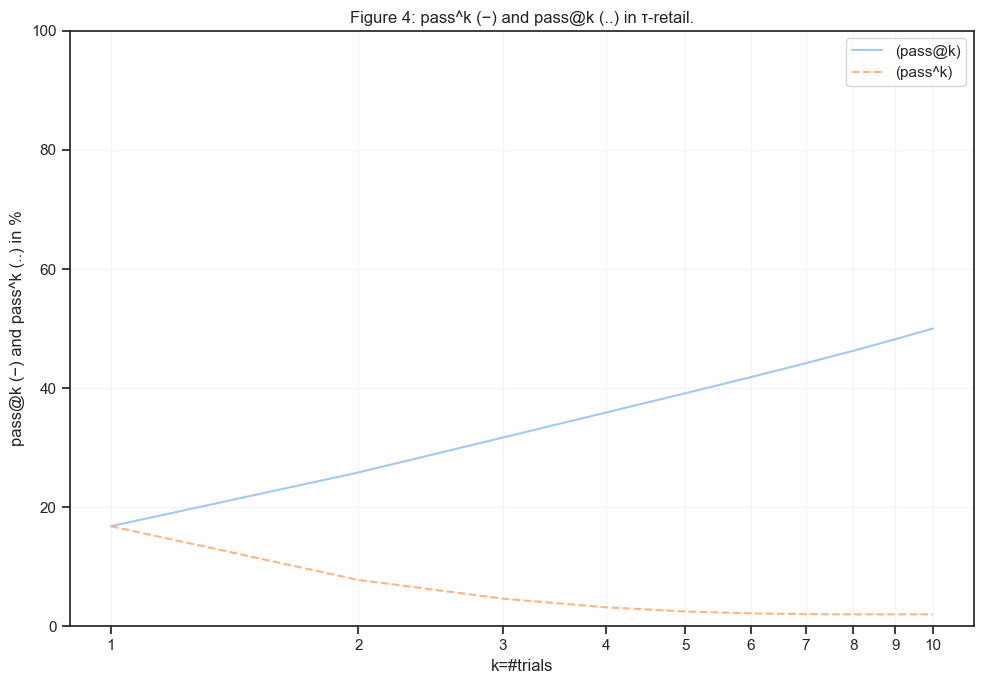

Number of trials per task: 10

pass@k values:
k=1: 16.8000%
k=2: 25.8222%
k=3: 31.7000%
k=4: 35.8857%
k=5: 39.1349%
k=6: 41.8286%
k=7: 44.1667%
k=8: 46.2667%
k=9: 48.2000%
k=10: 50.0000%

pass^k values:
k=1: 16.8000%
k=2: 7.7778%
k=3: 4.6333%
k=4: 3.1810%
k=5: 2.4841%
k=6: 2.1619%
k=7: 2.0333%
k=8: 2.0000%
k=9: 2.0000%
k=10: 2.0000%


In [33]:
# Function to calculate pass@k and pass^k from binary rewards
def calculate_metrics(results):
    # Extract task IDs and rewards
    task_ids = [result["task_id"] for result in results]
    unique_task_ids = set(task_ids)
    
    # Count successes per task
    successes_per_task = {}
    for result in results:
        task_id = result["task_id"]
        is_success = result["reward"] == 1.0  # Exactly 1.0 means success
        
        if task_id not in successes_per_task:
            successes_per_task[task_id] = 1 if is_success else 0
        else:
            successes_per_task[task_id] += 1 if is_success else 0
    
    # Number of trials per task
    num_trials = len(results) // len(unique_task_ids)
    k_values = list(range(1, num_trials + 1))
        
    # Calculate pass@k and pass^k for each k
    pass_at_k = []
    pass_k = []
    
    for k in k_values:
        sum_pass_at_k = 0
        sum_pass_k = 0
        
        for task_id, successes in successes_per_task.items():
            # pass^k = E_task[(c choose k)/(n choose k)]
            if k <= successes:
                # If we have more successes than k, the numerator is non-zero
                pass_k_task = comb(successes, k) / comb(num_trials, k)
            else:
                # If we have fewer successes than k, cannot choose k successes
                pass_k_task = 0
                
            # pass@k = 1 - E_task[((n-c) choose k)/(n choose k)]
            if k <= (num_trials - successes):
                # If we can choose k from the failures
                pass_at_k_task = 1 - (comb(num_trials - successes, k) / comb(num_trials, k))
            else:
                # If we cannot choose k from the failures, guaranteed to have a success
                pass_at_k_task = 1.0
                
            sum_pass_k += pass_k_task
            sum_pass_at_k += pass_at_k_task
        
        # Average over all tasks
        avg_pass_k = sum_pass_k / len(unique_task_ids)
        avg_pass_at_k = sum_pass_at_k / len(unique_task_ids)
        
        pass_k.append(avg_pass_k)
        pass_at_k.append(avg_pass_at_k)
    
    return k_values, pass_at_k, pass_k

# Load the data
with open(RESULTS_FILE, 'r') as f:
    data = json.load(f)

# Calculate metrics with the exact formulas
k_values, pass_at_k, pass_k = calculate_metrics(data)

plt.figure(figsize=(10, 7))
plt.plot(k_values, [p*100 for p in pass_at_k], '-', label='(pass@k)')
plt.plot(k_values, [p*100 for p in pass_k], '--', label='(pass^k)')

# Format plot
plt.xscale('log', base=2)  # Use base-2 logarithmic scale
plt.xticks(k_values, labels=[str(k) for k in k_values])  # Set explicit tick positions and labels
plt.xlabel('k=#trials')
plt.ylabel('pass@k (−) and pass^k (..) in %')
plt.title('Figure 4: pass^k (−) and pass@k (..) in τ-retail.')
plt.legend(loc='upper right')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.ylim(0, 100)

# Fix x-axis to ensure proper display of powers of 2
plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter())
plt.gca().xaxis.set_tick_params(which='minor', bottom=False)

# Save and show the plot
plt.tight_layout()
plt.savefig('pass_at_k_metrics_actual.png')
plt.show()

# Print the calculated values
print(f"Number of trials per task: {len(data) // len(set(r['task_id'] for r in data))}")
print("\npass@k values:")
for k, value in zip(k_values, pass_at_k):
    print(f"k={k}: {value*100:.4f}%")

print("\npass^k values:")
for k, value in zip(k_values, pass_k):
    print(f"k={k}: {value*100:.4f}%")

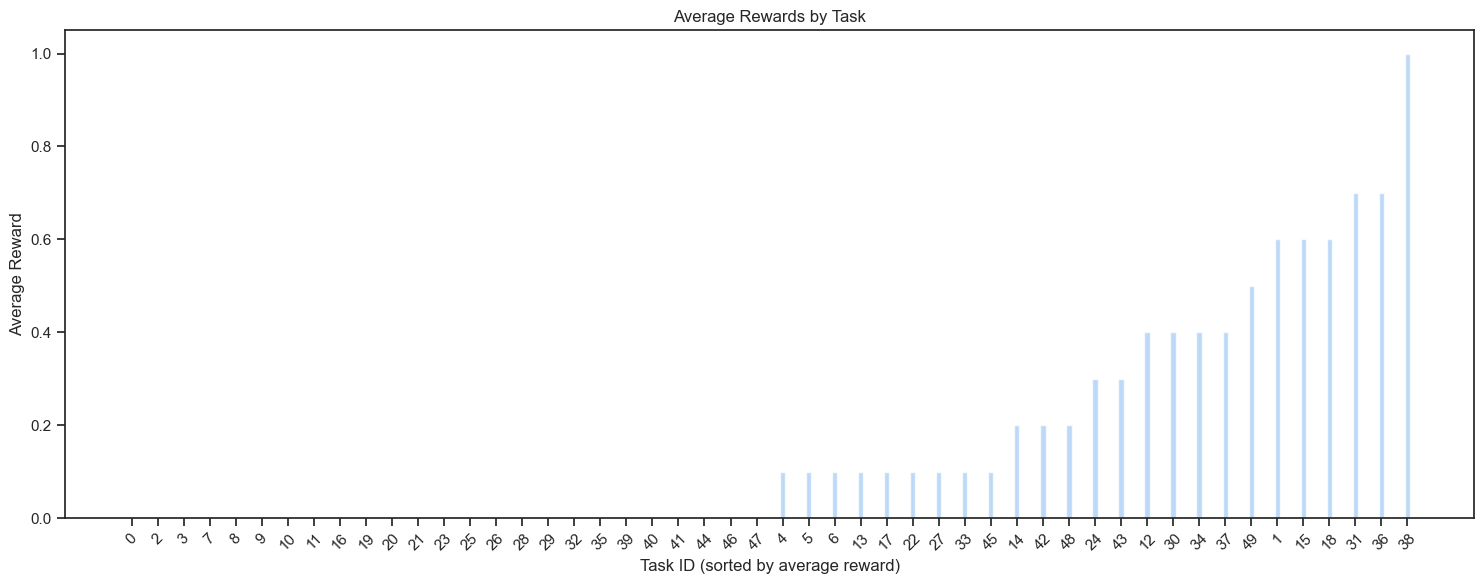

In [34]:
# Load the data
with open(RESULTS_FILE, 'r') as f:
    data = json.load(f)

# Create a dictionary to store rewards for each task
task_rewards = {}

# Extract task ID and reward for each result
for result in data:
    task_id = result["task_id"]
    reward = result["reward"]
    
    # Initialize list if first time seeing task
    if task_id not in task_rewards:
        task_rewards[task_id] = []
    
    # Add the reward to the task
    task_rewards[task_id].append(reward)

# Calculate average reward per task
avg_rewards = {task_id: np.mean(rewards) for task_id, rewards in task_rewards.items()}

# Sort tasks by average reward (from lowest to highest)
sorted_items = sorted(avg_rewards.items(), key=lambda x: x[1])
sorted_tasks = [item[0] for item in sorted_items]
sorted_rewards = [item[1] for item in sorted_items]

# Create a figure
plt.figure(figsize=(15, 6))

# Plot bars in sorted order
x_positions = np.arange(len(sorted_tasks))
plt.bar(x_positions, sorted_rewards, width=0.2, alpha=0.7)

# Format the plot
plt.xlabel('Task ID (sorted by average reward)')
plt.ylabel('Average Reward')
plt.title('Average Rewards by Task')

# Set the x-ticks to be the task IDs, rotated for readability
plt.xticks(x_positions, sorted_tasks, rotation=45)
plt.tight_layout()

# Save the figure
plt.savefig('average_rewards_by_task.png')
plt.show()